In [1]:
import numpy as np
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## data
in this file we can visualize the motion data of one perticular frame

please **run asfamc2tensor.py first** to generate the coordinates of nodes and adjacency matrix

In [2]:
# %load asfamc2tensor.py
import numpy as np
import matplotlib.pyplot as plt
from transforms3d.euler import euler2mat
from mpl_toolkits.mplot3d import Axes3D
import pickle
import torch

class Joint:
  def __init__(self, name, direction, length, axis, dof, limits):
    """
    Definition of basic joint. The joint also contains the information of the
    bone between it's parent joint and itself. Refer
    [here](https://research.cs.wisc.edu/graphics/Courses/cs-838-1999/Jeff/ASF-AMC.html)
    for detailed description for asf files.

    Parameter
    ---------
    name: Name of the joint defined in the asf file. There should always be one
    root joint. String.

    direction: Default direction of the joint(bone). The motions are all defined
    based on this default pose.

    length: Length of the bone.

    axis: Axis of rotation for the bone.

    dof: Degree of freedom. Specifies the number of motion channels and in what
    order they appear in the AMC file.

    limits: Limits on each of the channels in the dof specification

    """
    self.name = name
    self.direction = np.reshape(direction, [3, 1])
    self.length = length
    axis = np.deg2rad(axis)
    self.C = euler2mat(*axis)
    self.Cinv = np.linalg.inv(self.C)
    self.limits = np.zeros([3, 2])
    for lm, nm in zip(limits, dof):
      if nm == 'rx':
        self.limits[0] = lm
      elif nm == 'ry':
        self.limits[1] = lm
      else:
        self.limits[2] = lm
    self.parent = None
    self.children = []
    self.coordinate = None
    self.matrix = None

  def set_motion(self, motion):
    if self.name == 'root':
      self.coordinate = np.reshape(np.array(motion['root'][:3]), [3, 1])
      rotation = np.deg2rad(motion['root'][3:])
      self.matrix = self.C.dot(euler2mat(*rotation)).dot(self.Cinv)
    else:
      idx = 0
      rotation = np.zeros(3)
      for axis, lm in enumerate(self.limits):
        if not np.array_equal(lm, np.zeros(2)):
          rotation[axis] = motion[self.name][idx]
          idx += 1
      rotation = np.deg2rad(rotation)
      self.matrix = self.parent.matrix.dot(self.C).dot(euler2mat(*rotation)).dot(self.Cinv)
      self.coordinate = self.parent.coordinate + self.length * self.matrix.dot(self.direction)
    for child in self.children:
      child.set_motion(motion)

  def draw(self):
    joints = self.to_dict()
    # print(joints.values())
    # d()
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.set_xlim3d(-50, 10)
    ax.set_ylim3d(-20, 40)
    ax.set_zlim3d(-20, 40)

    xs, ys, zs = [], [], []
    for joint in joints.values():
      xs.append(joint.coordinate[0, 0])
      ys.append(joint.coordinate[1, 0])
      zs.append(joint.coordinate[2, 0])
    # plt.plot(zs, xs, ys, 'r')
    plt.plot(zs, xs, ys, 'b.')

    for joint in joints.values():
      child = joint
      if child.parent is not None:
        parent = child.parent
        xs = [child.coordinate[0, 0], parent.coordinate[0, 0]]
        ys = [child.coordinate[1, 0], parent.coordinate[1, 0]]
        zs = [child.coordinate[2, 0], parent.coordinate[2, 0]]
        # plt.plot(zs, xs, ys, 'b.')
        plt.plot(zs, xs, ys, 'r')
    plt.show()

  def save_data(self):
    joints = self.to_dict()
    # print(joints.values())
    # d()
    coos = {} #coordinates for all nodes
    for joint in joints.values():
      px = joint.coordinate[0, 0]
      py = joint.coordinate[1, 0]
      pz = joint.coordinate[2, 0]
      coos[joint.name] = [px,py,pz]

    edges = []
    for joint in joints.values():
      child = joint
      if child.parent is not None:
        parent = child.parent
        edges.append([child.name,parent.name])
        xs = [child.coordinate[0, 0], parent.coordinate[0, 0]]
        ys = [child.coordinate[1, 0], parent.coordinate[1, 0]]
        zs = [child.coordinate[2, 0], parent.coordinate[2, 0]]
        # plt.plot(zs, xs, ys, 'b.')
    #     plt.plot(zs, xs, ys, 'r')
    # plt.show()
    # print(edges)
    # generate adj
    N = len(coos)
    adj = torch.zeros(N,N)
    name2num = []
    for j in coos:
      name2num.append(j)
    # generate adj
    for e in edges:
      st = name2num.index(e[0])
      ed = name2num.index(e[1])
      adj[st,ed] = adj[ed,st] = 1
    # generate xs as N*d format
    xs = []
    for j in coos:
      xs.append(coos[j])
    xs = torch.tensor(xs)
    # normalization
    t = [torch.min(xs[:,0]),torch.min(xs[:,1]),torch.min(xs[:,2])]
    t= torch.tensor(t).unsqueeze(0).repeat(xs.shape[0],1)
    xs = xs-t

    maxn = np.max((torch.max(xs[:,0]),torch.max(xs[:,1]),torch.max(xs[:,2])))
    t = [maxn,maxn,maxn]
    t= torch.tensor(t).unsqueeze(0).repeat(xs.shape[0],1)
    H0 = xs/t
    # print(H0)
    # return coos,edges
    return adj,H0

  def to_dict(self):
    ret = {self.name: self}
    for child in self.children:
      ret.update(child.to_dict())
    return ret

  def pretty_print(self):
    print('===================================')
    print('joint: %s' % self.name)
    print('direction:')
    print(self.direction)
    print('limits:', self.limits)
    print('parent:', self.parent)
    print('children:', self.children)


def read_line(stream, idx):
  if idx >= len(stream):
    return None, idx
  line = stream[idx].strip().split()
  idx += 1
  return line, idx


def parse_asf(file_path):
  '''read joint data only'''
  with open(file_path) as f:
    content = f.read().splitlines()

  for idx, line in enumerate(content):
    # meta infomation is ignored
    if line == ':bonedata':
      content = content[idx+1:]
      break

  # read joints
  joints = {'root': Joint('root', np.zeros(3), 0, np.zeros(3), [], [])}
  idx = 0
  while True:
    # the order of each section is hard-coded

    line, idx = read_line(content, idx)

    if line[0] == ':hierarchy':
      break

    assert line[0] == 'begin'

    line, idx = read_line(content, idx)
    assert line[0] == 'id'

    line, idx = read_line(content, idx)
    assert line[0] == 'name'
    name = line[1]

    line, idx = read_line(content, idx)
    assert line[0] == 'direction'
    direction = np.array([float(axis) for axis in line[1:]])

    # skip length
    line, idx = read_line(content, idx)
    assert line[0] == 'length'
    length = float(line[1])

    line, idx = read_line(content, idx)
    assert line[0] == 'axis'
    assert line[4] == 'XYZ'

    axis = np.array([float(axis) for axis in line[1:-1]])

    dof = []
    limits = []

    line, idx = read_line(content, idx)
    if line[0] == 'dof':
      dof = line[1:]
      for i in range(len(dof)):
        line, idx = read_line(content, idx)
        if i == 0:
          assert line[0] == 'limits'
          line = line[1:]
        assert len(line) == 2
        mini = float(line[0][1:])
        maxi = float(line[1][:-1])
        limits.append((mini, maxi))

      line, idx = read_line(content, idx)

    assert line[0] == 'end'
    joints[name] = Joint(
      name,
      direction,
      length,
      axis,
      dof,
      limits
    )

  # read hierarchy
  assert line[0] == ':hierarchy'

  line, idx = read_line(content, idx)

  assert line[0] == 'begin'

  while True:
    line, idx = read_line(content, idx)
    if line[0] == 'end':
      break
    assert len(line) >= 2
    for joint_name in line[1:]:
      joints[line[0]].children.append(joints[joint_name])
    for nm in line[1:]:
      joints[nm].parent = joints[line[0]]

  return joints


def parse_amc(file_path):
  with open(file_path) as f:
    content = f.read().splitlines()

  for idx, line in enumerate(content):
    if line == ':DEGREES':
      content = content[idx+1:]
      break

  frames = []
  idx = 0
  line, idx = read_line(content, idx)
  assert line[0].isnumeric(), line
  EOF = False
  while not EOF:
    joint_degree = {}
    while True:
      line, idx = read_line(content, idx)
      if line is None:
        EOF = True
        break
      if line[0].isnumeric():
        break
      joint_degree[line[0]] = [float(deg) for deg in line[1:]]
    frames.append(joint_degree)
  return frames



if __name__ == '__main__':
  # address of asf and amc file (01.asf for walking and 09.asf for running)
  asf_path = '01.asf'
  amc_path = '01.amc'
  # generate the data
  joints = parse_asf(asf_path)
  motions = parse_amc(amc_path)

  # data to tensor
  print('frame num:',len(motions))
  h0s = []
  for frame_idx in range(len(motions)):
    joints['root'].set_motion(motions[frame_idx])
    adj,h0 = joints['root'].save_data()
    h0s.append(h0.unsqueeze(0))
  h0s = torch.cat(h0s,dim=0)

  # save
  print(h0s.shape)
  torch.save(adj,'./adj01.pkl')
  torch.save(h0s,'./xs01.pkl')



frame num: 343
torch.Size([343, 31, 3])


In [3]:
adj = torch.load('adj09.pkl')
xs = torch.load('xs09.pkl')

## draw

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
H0 = xs[0,:,:]
N = adj.shape[0]

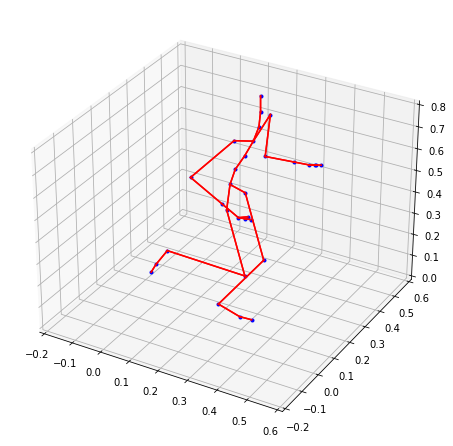

In [6]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

ax.set_xlim3d(-0.2,0.6)
ax.set_ylim3d(-0.2,0.6)
ax.set_zlim3d(0,0.8)

xs, ys, zs = [], [], []
for i in range(H0.shape[0]):
    xs.append(H0[i,0])
    ys.append(H0[i,1])
    zs.append(H0[i,2])

plt.plot(zs, xs, ys, 'b.')

# for edge in edges:
for i in range(N):
    for j in range(N):
        if adj[i,j] == 1:
            xs = [H0[i,0],H0[j,0]]
            ys = [H0[i,1],H0[j,1]]
            zs = [H0[i,2],H0[j,2]]
            plt.plot(zs, xs, ys, 'r')

plt.show()

In [7]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

In [8]:
adj = torch.load('adj09.pkl')
data = torch.load('xs09.pkl')

adj1 = torch.load('adj01.pkl')
data1 = torch.load('xs01.pkl')

In [9]:
N = adj.shape[0]
steps = [0,20,40,60]

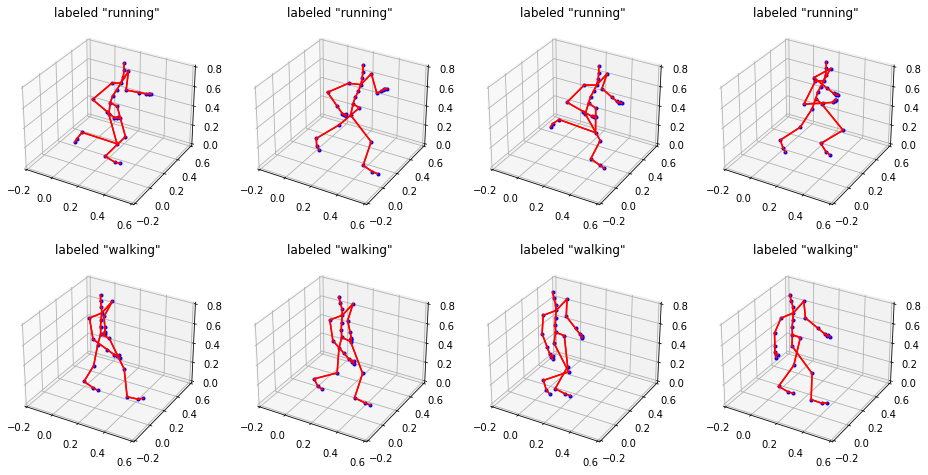

In [10]:
fig = plt.figure(figsize=(16, 8))
# draw running img
for m in range(4):
    H0 = data[steps[m],:,:]
    ax = fig.add_subplot(2, 4, m+1, projection='3d')

    ax.set_xlim3d(-0.2,0.6)
    ax.set_ylim3d(-0.2,0.6)
    ax.set_zlim3d(0,0.8)

    xs, ys, zs = [], [], []
    for i in range(H0.shape[0]):
        xs.append(H0[i,0])
        ys.append(H0[i,1])
        zs.append(H0[i,2])

    plt.plot(zs, xs, ys, 'b.')
    # for edge in edges:
    for i in range(N):
        for j in range(N):
            if adj[i,j] == 1:
                xs = [H0[i,0],H0[j,0]]
                ys = [H0[i,1],H0[j,1]]
                zs = [H0[i,2],H0[j,2]]
                plt.plot(zs, xs, ys, 'r')
    plt.title('labeled "running"')
# draw walking img
for m in range(4):
    H0 = data1[steps[m],:,:]
    ax = fig.add_subplot(2, 4, m+5, projection='3d')

    ax.set_xlim3d(-0.2,0.6)
    ax.set_ylim3d(-0.2,0.6)
    ax.set_zlim3d(0,0.8)

    xs, ys, zs = [], [], []
    for i in range(H0.shape[0]):
        xs.append(H0[i,0])
        ys.append(H0[i,1])
        zs.append(H0[i,2])

    plt.plot(zs, xs, ys, 'b.')
    # for edge in edges:
    for i in range(N):
        for j in range(N):
            if adj[i,j] == 1:
                xs = [H0[i,0],H0[j,0]]
                ys = [H0[i,1],H0[j,1]]
                zs = [H0[i,2],H0[j,2]]
                plt.plot(zs, xs, ys, 'r')
    plt.title('labeled "walking"')


                